In [1]:
import pandas as pd
import json
from sacrebleu.metrics import BLEU
from comet import download_model, load_from_checkpoint

C:\Users\siemb\.conda\envs\MT_COMET\lib\site-packages\torchmetrics\utilities\imports.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [271]:
# Making the dataframe useable/modifyable
XCT_DE = pd.read_json("data/xct/references/all/th_TH.jsonl", lines = True)
# Copying so the original dataframe won't be changed
XCT_DE = XCT_DE.copy()

# Creating a dataset which only contains the sentences to be translated
XCT_IN = XCT_DE['source']
# Creating a dataset which only containes the 'correctly' translated sentences
XCT_TARGET = XCT_DE['targets']

# Mofidying the target dataset, because it is still written as a list instead of a dictionary which can be used for the dataframe
XCT_TARGET = XCT_TARGET.apply(lambda x: pd.Series(x[0]))

# Creating a dataset with just the ID for the m-Eta metric
XCT_ID = XCT_DE['id']

# Importing the translations for evaluation
translation_df = pd.read_csv("Prompt-Engineered_translation/Llama/COT/translation_COT_LLAMA_TH.csv")
# Creating a copy for the same reaseon as the input dataframe
translation_df = translation_df.copy()

XCT_ID = pd.DataFrame({'id': XCT_ID, 'translation': translation_df['0']})

In [272]:
from sacrebleu.metrics import BLEU, CHRF, TER


TARGET_CHECKLIST = []
for x in XCT_TARGET['translation']:
    TARGET_CHECKLIST.append(str(x))

SYSTEM_CHECKLIST = []
for x in translation_df['0']:
    SYSTEM_CHECKLIST.append(str(x))

bleu = BLEU(tokenize = 'char')
bleu.corpus_score(SYSTEM_CHECKLIST, [TARGET_CHECKLIST])

BLEU = 40.49 61.5/41.8/34.9/29.9 (BP = 1.000 ratio = 1.007 hyp_len = 207637 ref_len = 206189)

In [273]:
bleu.get_signature()


nrefs:1|case:mixed|eff:no|tok:char|smooth:exp|version:2.5.1

In [274]:
chrf = CHRF()

chrf.corpus_score(SYSTEM_CHECKLIST, [TARGET_CHECKLIST])

chrF2 = 36.36

In [275]:
comet_list = []
for x in range(len(XCT_DE)):
    comet_dict = {}
    comet_dict["src"] = XCT_IN[x]
    comet_dict["mt"] = translation_df['0'][x]
    comet_dict["ref"] = XCT_TARGET['translation'][x]
    comet_list.append(comet_dict)

In [276]:
##### from comet import download_model, load_from_checkpoint
# Choose your model from Hugging Face Hub
model_path = download_model("Unbabel/wmt22-comet-da")
# or for example:
# model_path = download_model("Unbabel/wmt22-comet-da")

# Load the model checkpoint:
model = load_from_checkpoint(model_path)

# Call predict method:
model_output = model.predict(comet_list, batch_size=8, gpus=1)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\siemb\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\2760a223ac957f30acfb18c8aa649b01cf1d75f2\checkpoints\model.ckpt`
Encoder model frozen.
C:\Users\siemb\.conda\envs\MT_COMET\lib\site-packages\pytorch_lightning\core\saving.py:197: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 529/529 [01:04<00:0

In [277]:
# Sentence-level scores (list)
# model_output.scores

In [278]:
# System-level score (float)
model_output.system_score

0.7186320297085366

In [279]:
# m-Eta metric

mEta_list = []
for x in range(len(XCT_ID)):
    mEta_dict = {}
    mEta_dict["id"] = XCT_ID['id'].loc[x]
    mEta_dict["prediction"] = XCT_ID['translation'].loc[x]
    mEta_list.append(mEta_dict)

with open("predictions_Llama_COT_TH.jsonl", "w", encoding="utf-8") as f:
    for item in mEta_list:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

In [280]:
!python src/evaluation/evaluate.py \
   --references "data/xct/references/all/th_TH.jsonl" \
   --predictions "predictions_Llama_COT_TH.jsonl"

INFO | Running evaluation on XC-Translate with the following parameters:
INFO |  - References: data/xct/references/all/th_TH.jsonl
INFO |  - Predictions: predictions_Llama_COT_TH.jsonl
INFO |  - Entity types: None
INFO |  - Verbose: False
INFO | 
INFO | Loading data from data/xct/references/all/th_TH.jsonl...
INFO | Loaded 4230 instances.
INFO | Loading data from predictions_Llama_COT_TH.jsonl...
INFO | Loaded 4230 predictions.
INFO | Computing entity name translation accuracy...
INFO | 
INFO | =============================================
INFO | Evaluation results:
INFO | Correct instances   = 236
INFO | Total instances     = 4230
INFO | -----------------------------
INFO | m-ETA               = 5.58
INFO | =============================================
INFO | 
INFO | Evaluation completed.


# Baseline tables and figures

In [283]:
country_names = ['Arabic', 'Germany', 'France', 'Spain', 'Italy', 'Japanese', 'Korean', 'Thai', 'China', 'Turkey']
index_metric_names = ['BLEU', 'CHRF', 'COMET', 'M-ETA']

column_Tower_Germany = pd.Series(data = [44.61, 68.78, 88.96, 34.96],index = index_metric_names, name = 'Germany')
column_Tower_France = pd.Series(data = [48.97, 71.17, 87.73, 32.44], index = index_metric_names, name = 'France')
column_Tower_Spain = pd.Series(data = [56.53, 76.05, 91.17, 43.89], index = index_metric_names, name = 'Spain')
column_Tower_Italy = pd.Series(data = [47.37, 69.26, 89.48, 36.45], index = index_metric_names, name = 'Italy')
column_Tower_Japan = pd.Series(data = [38.40, 45.46, 91.25, 33.93], index = index_metric_names, name = 'Japan')
column_Tower_Korea = pd.Series(data = [41.50, 49.21, 91.29, 32.59], index = index_metric_names, name = 'Korea')
column_Tower_Thailand = pd.Series(data = [33.81, 33.60, 74.11, 2.70], index = index_metric_names, name = 'Thailand')
column_Tower_China = pd.Series(data = [20.09, 19.22, 87.37, 6.61], index = index_metric_names, name = 'China')


Compare_df_Tower = pd.DataFrame(data = {"German": column_Tower_Germany, "French": column_Tower_France, "Spanish": column_Tower_Spain, 
                                  "Italian": column_Tower_Italy, "Japanese": column_Tower_Japan, "Korean": column_Tower_Korea, 
                                    "Chinese": column_Tower_China, "Thai": column_Tower_Thailand})

Compare_df_Tower.style.set_caption("Tower LLM 9B baseline") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-weight', 'bold'),
                  ('font-size', '16px')]}
    ]) \
    .format("{:.2f}")


,German,French,Spanish,Italian,Japanese,Korean,Chinese,Thai
BLEU,44.61,48.97,56.53,47.37,38.40,41.50,20.09,33.81
CHRF,68.78,71.17,76.05,69.26,45.46,49.21,19.22,33.60
COMET,88.96,87.73,91.17,89.48,91.25,91.29,87.37,74.11
M-ETA,34.96,32.44,43.89,36.45,33.93,32.59,6.61,2.70


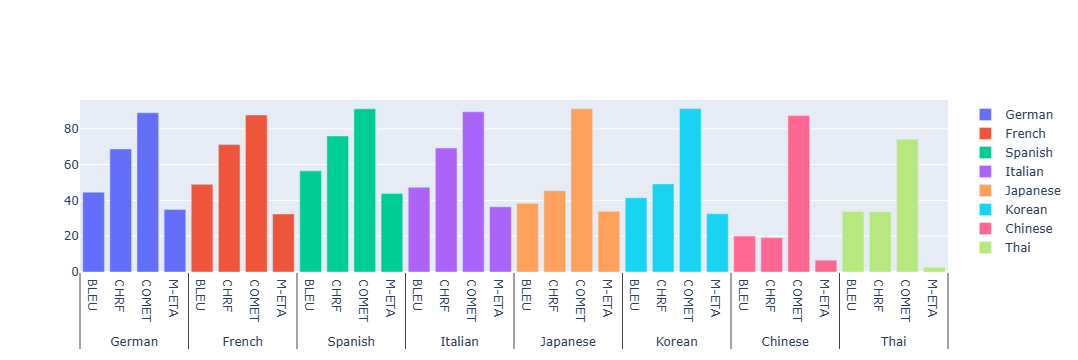

In [284]:
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

fig_Tower = go.Figure()
for country, values in Compare_df_Tower.items():
    fig_Tower.add_bar(
        x=[[country]*len(index_metric_names), index_metric_names],
        y=values,
        name=country
    )

fig_Tower.show()

In [285]:
column_Euro_Germany = pd.Series(data = [43.67, 67.62, 88.92, 39.78],index = index_metric_names, name = 'Germany')
column_Euro_France = pd.Series(data = [48.32, 69.54, 86.93, 39.13], index = index_metric_names, name = 'France')
column_Euro_Spain = pd.Series(data = [54.44, 72.89, 90.72, 46.74], index = index_metric_names, name = 'Spain')
column_Euro_Italy = pd.Series(data = [47.68, 68.80, 89.31, 40.06], index = index_metric_names, name = 'Italy')
column_Euro_Japan = pd.Series(data = [32.80, 43.41, 90.92, 35.35], index = index_metric_names, name = 'Japan')
column_Euro_Korea = pd.Series(data = [38.50, 46.84, 90.99, 29.90], index = index_metric_names, name = 'Korea')
column_Euro_China = pd.Series(data = [19.10, 18.11, 86.81, 7.36], index = index_metric_names, name = 'China')
column_Euro_Arabic = pd.Series(data = [30.26, 61.73, 89.14, 31.95], index = index_metric_names, name = 'Arabic')
column_Euro_Turkey = pd.Series(data = [35.71, 66.39, 91.53, 38.62], index = index_metric_names, name = 'Turkey')



Compare_df_Euro = pd.DataFrame(data = {"German": column_Euro_Germany, "French": column_Euro_France, "Spanish": column_Euro_Spain, 
                                "Italian": column_Euro_Italy, "Japanese": column_Euro_Japan, "Korean": column_Euro_Korea, 
                                "Chinese": column_Euro_China, "Arabic": column_Euro_Arabic, "Turkish": column_Euro_Turkey})

Compare_df_Euro.style.set_caption("Euro LLM 9B baseline") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-weight', 'bold'),
                  ('font-size', '16px')]}
    ])\
    .format("{:.2f}")


,German,French,Spanish,Italian,Japanese,Korean,Chinese,Arabic,Turkish
BLEU,43.67,48.32,54.44,47.68,32.80,38.50,19.10,30.26,35.71
CHRF,67.62,69.54,72.89,68.80,43.41,46.84,18.11,61.73,66.39
COMET,88.92,86.93,90.72,89.31,90.92,90.99,86.81,89.14,91.53
M-ETA,39.78,39.13,46.74,40.06,35.35,29.90,7.36,31.95,38.62


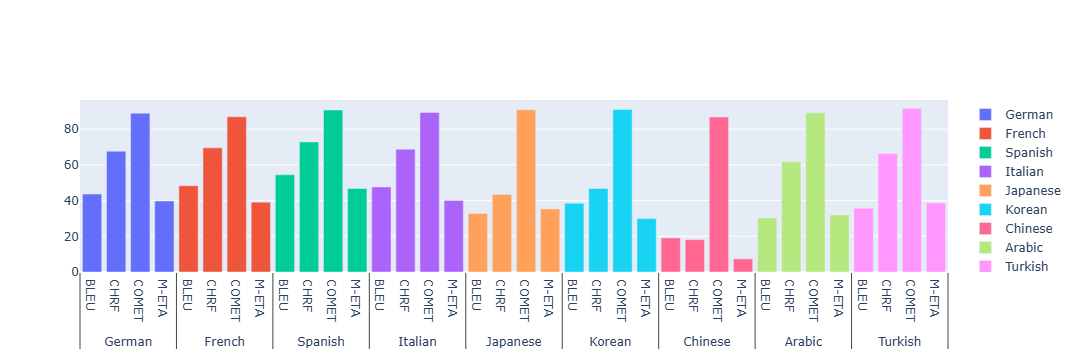

In [286]:
fig_Euro = go.Figure()
for country, values in Compare_df_Euro.items():
    fig_Euro.add_bar(
        x=[[country]*len(index_metric_names), index_metric_names],
        y=values,
        name=country
    )

fig_Euro.show()

In [287]:
column_Gemma_Germany = pd.Series(data = [39.42, 64.60, 87.53, 32.71],index = index_metric_names, name = 'Germany')
column_Gemma_France = pd.Series(data = [46.35, 69.53, 86.93, 33.37], index = index_metric_names, name = 'France')
column_Gemma_Spain = pd.Series(data = [52.43, 73.17, 90.22, 40.48], index = index_metric_names, name = 'Spain')
column_Gemma_Italy = pd.Series(data = [42.50, 67.49, 87.92, 34.66], index = index_metric_names, name = 'Italy')
column_Gemma_Japan = pd.Series(data = [28.90, 39.44, 88.18, 28.66], index = index_metric_names, name = 'Japan')
column_Gemma_Korea = pd.Series(data = [26.50, 35.45, 86.10, 30.25], index = index_metric_names, name = 'Korea')
column_Gemma_China = pd.Series(data = [15.44, 16.38, 84.05, 6.11], index = index_metric_names, name = 'China')
column_Gemma_Arabic = pd.Series(data = [28.89, 58.79, 87.23, 28.28], index = index_metric_names, name = 'Arabic')
column_Gemma_Turkey = pd.Series(data = [28.18, 61.48, 89.17, 32.03], index = index_metric_names, name = 'Turkey')
column_Gemma_Thai = pd.Series(data = [45.59, 47.01, 82.12, 11.58], index = index_metric_names, name = 'Thailand')



Compare_df_Gemma = pd.DataFrame(data = {"German": column_Gemma_Germany, "French": column_Gemma_France, "Spanish": column_Gemma_Spain, 
                                "Italian": column_Gemma_Italy, "Japanese": column_Gemma_Japan, "Korean": column_Gemma_Korea, 
                                "Chinese": column_Gemma_China, "Arabic": column_Gemma_Arabic, "Turkish": column_Gemma_Turkey, 
                                "Thai": column_Gemma_Thai})

Compare_df_Gemma.style.set_caption("Gemma 3 12B baseline") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-weight', 'bold'),
                  ('font-size', '16px')]}
    ])\
    .format("{:.2f}")


,German,French,Spanish,Italian,Japanese,Korean,Chinese,Arabic,Turkish,Thai
BLEU,39.42,46.35,52.43,42.50,28.90,26.50,15.44,28.89,28.18,45.59
CHRF,64.60,69.53,73.17,67.49,39.44,35.45,16.38,58.79,61.48,47.01
COMET,87.53,86.93,90.22,87.92,88.18,86.10,84.05,87.23,89.17,82.12
M-ETA,32.71,33.37,40.48,34.66,28.66,30.25,6.11,28.28,32.03,11.58


In [288]:
column_Qwen_Germany = pd.Series(data = [29.81, 58.37, 85.18, 19.04],index = index_metric_names, name = 'Germany')
column_Qwen_France = pd.Series(data = [38.11, 62.74, 84.19, 21.98], index = index_metric_names, name = 'France')
column_Qwen_Spain = pd.Series(data = [45.16, 67.57, 88.42, 26.64], index = index_metric_names, name = 'Spain')
column_Qwen_Italy = pd.Series(data = [38.07, 62.05, 86.12, 22.27], index = index_metric_names, name = 'Italy')
column_Qwen_Japan = pd.Series(data = [30.50, 34.42, 85.93, 11.60], index = index_metric_names, name = 'Japan')
column_Qwen_Korea = pd.Series(data = [22.30, 32.20, 82.78, 8.92], index = index_metric_names, name = 'Korea')
column_Qwen_China = pd.Series(data = [18.90, 17.49, 84.81, 5.64], index = index_metric_names, name = 'China')
column_Qwen_Arabic = pd.Series(data = [19.64, 45.62, 79.44, 9.46], index = index_metric_names, name = 'Arabic')
column_Qwen_Turkey = pd.Series(data = [14.34, 47.24, 82.20, 15.81], index = index_metric_names, name = 'Turkey')
column_Qwen_Thai = pd.Series(data = [36.48, 33.63, 72.55, 2.34], index = index_metric_names, name = 'Thailand')



Compare_df_Qwen = pd.DataFrame(data = {"German": column_Qwen_Germany, "French": column_Qwen_France, "Spanish": column_Qwen_Spain, 
                                "Italian": column_Qwen_Italy, "Japanese": column_Qwen_Japan, "Korean": column_Qwen_Korea, 
                                "Chinese": column_Qwen_China, "Arabic": column_Qwen_Arabic, "Turkish": column_Qwen_Turkey, 
                                "Thai": column_Qwen_Thai})

Compare_df_Qwen.style.set_caption("Qwen 2.5 7B baseline") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-weight', 'bold'),
                  ('font-size', '16px')]}
    ])\
    .format("{:.2f}")


,German,French,Spanish,Italian,Japanese,Korean,Chinese,Arabic,Turkish,Thai
BLEU,29.81,38.11,45.16,38.07,30.50,22.30,18.90,19.64,14.34,36.48
CHRF,58.37,62.74,67.57,62.05,34.42,32.20,17.49,45.62,47.24,33.63
COMET,85.18,84.19,88.42,86.12,85.93,82.78,84.81,79.44,82.20,72.55
M-ETA,19.04,21.98,26.64,22.27,11.60,8.92,5.64,9.46,15.81,2.34


In [289]:
column_Llama_Germany = pd.Series(data = [36.63, 63.47, 86.41, 26.55],index = index_metric_names, name = 'Germany')
column_Llama_France = pd.Series(data = [40.01, 65.08, 84.97, 25.80], index = index_metric_names, name = 'France')
column_Llama_Spain = pd.Series(data = [49.56, 71.43, 89.40, 31.99], index = index_metric_names, name = 'Spain')
column_Llama_Italy = pd.Series(data = [40.29, 63.77, 86.92, 27.13], index = index_metric_names, name = 'Italy')
column_Llama_Japan = pd.Series(data = [29.90, 35.94, 86.58, 17.92], index = index_metric_names, name = 'Japan')
column_Llama_Korea = pd.Series(data = [25.00, 34.12, 86.63, 15.44], index = index_metric_names, name = 'Korea')
column_Llama_China = pd.Series(data = [19.70, 18.86, 83.79, 6.89], index = index_metric_names, name = 'China')
column_Llama_Arabic = pd.Series(data = [22.58, 52.08, 84.03, 17.51], index = index_metric_names, name = 'Arabic')
column_Llama_Turkey = pd.Series(data = [24.43, 57.18, 87.75, 23.39], index = index_metric_names, name = 'Turkey')
column_Llama_Thai = pd.Series(data = [44.61, 40.39, 75.62, 7.83], index = index_metric_names, name = 'Thailand')



Compare_df_Llama = pd.DataFrame(data = {"German": column_Llama_Germany, "French": column_Llama_France, "Spanish": column_Llama_Spain, 
                                "Italian": column_Llama_Italy, "Japanese": column_Llama_Japan, "Korean": column_Llama_Korea, 
                                "Chinese": column_Llama_China, "Arabic": column_Llama_Arabic, "Turkish": column_Llama_Turkey, 
                                "Thai": column_Llama_Thai})

Compare_df_Llama.style.set_caption("Llama 3.1 8B baseline") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-weight', 'bold'),
                  ('font-size', '16px')]}
    ])\
    .format("{:.2f}")


,German,French,Spanish,Italian,Japanese,Korean,Chinese,Arabic,Turkish,Thai
BLEU,36.63,40.01,49.56,40.29,29.90,25.00,19.70,22.58,24.43,44.61
CHRF,63.47,65.08,71.43,63.77,35.94,34.12,18.86,52.08,57.18,40.39
COMET,86.41,84.97,89.40,86.92,86.58,86.63,83.79,84.03,87.75,75.62
M-ETA,26.55,25.80,31.99,27.13,17.92,15.44,6.89,17.51,23.39,7.83


# Zero-shot tables and figures

In [290]:
country_names = ['Arabic', 'Germany', 'France', 'Spain', 'Italy', 'Japanese', 'Korean', 'Thai', 'China', 'Turkey']
index_metric_names = ['BLEU', 'CHRF', 'COMET', 'M-ETA']

column_Tower_ZS_Germany = pd.Series(data = [45.49, 69.42, 89.01, 33.32],index = index_metric_names, name = 'Germany')
column_Tower_ZS_France = pd.Series(data = [53.30, 73.41, 87.76, 35.14], index = index_metric_names, name = 'France')
column_Tower_ZS_Spain = pd.Series(data = [59.93, 77.74, 91.33, 42.48], index = index_metric_names, name = 'Spain')
column_Tower_ZS_Italy = pd.Series(data = [50.80, 71.34, 89.66, 35.84], index = index_metric_names, name = 'Italy')
column_Tower_ZS_Japan = pd.Series(data = [40.60, 47.34, 91.30, 32.23], index = index_metric_names, name = 'Japan')
column_Tower_ZS_Korea = pd.Series(data = [39.40, 48.05, 91.05, 30.34], index = index_metric_names, name = 'Korea')
column_Tower_ZS_Thailand = pd.Series(data = [35.63, 36.12, 74.28, 2.79], index = index_metric_names, name = 'Thailand')
column_Tower_ZS_China = pd.Series(data = [20.70, 19.65, 87.28, 6.86], index = index_metric_names, name = 'China')


Compare_df_Tower_ZS = pd.DataFrame(data = {"German": column_Tower_ZS_Germany, "French": column_Tower_ZS_France, "Spanish": column_Tower_ZS_Spain, 
                                  "Italian": column_Tower_ZS_Italy, "Japanese": column_Tower_ZS_Japan, "Korean": column_Tower_ZS_Korea, 
                                    "Chinese": column_Tower_ZS_China, "Thai": column_Tower_ZS_Thailand})

Compare_df_Tower_ZS.style.set_caption("Tower LLM 9B zero-shot") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-weight', 'bold'),
                  ('font-size', '16px')]}
    ]) \
    .format("{:.2f}")


,German,French,Spanish,Italian,Japanese,Korean,Chinese,Thai
BLEU,45.49,53.30,59.93,50.80,40.60,39.40,20.70,35.63
CHRF,69.42,73.41,77.74,71.34,47.34,48.05,19.65,36.12
COMET,89.01,87.76,91.33,89.66,91.30,91.05,87.28,74.28
M-ETA,33.32,35.14,42.48,35.84,32.23,30.34,6.86,2.79


In [291]:
column_Euro_ZS_Germany = pd.Series(data = [46.71, 69.22, 88.67, 38.52],index = index_metric_names, name = 'Germany')
column_Euro_ZS_France = pd.Series(data = [52.03, 72.52, 87.49, 38.49], index = index_metric_names, name = 'France')
column_Euro_ZS_Spain = pd.Series(data = [59.06, 76.64, 91.16, 47.02], index = index_metric_names, name = 'Spain')
column_Euro_ZS_Italy = pd.Series(data = [50.97, 71.25, 89.67, 39.23], index = index_metric_names, name = 'Italy')
column_Euro_ZS_Japan = pd.Series(data = [38.50, 46.05, 91.00, 33.01], index = index_metric_names, name = 'Japan')
column_Euro_ZS_Korea = pd.Series(data = [41.0, 48.75, 90.87, 28.81], index = index_metric_names, name = 'Korea')
column_Euro_ZS_China = pd.Series(data = [19.70, 18.72, 87.02, 7.16], index = index_metric_names, name = 'China')
column_Euro_ZS_Arabic = pd.Series(data = [33.54, 63.43, 89.13, 31.67], index = index_metric_names, name = 'Arabic')
column_Euro_ZS_Turkey = pd.Series(data = [37.96, 67.24, 91.41, 37.29], index = index_metric_names, name = 'Turkey')



Compare_df_Euro_ZS = pd.DataFrame(data = {"German": column_Euro_ZS_Germany, "French": column_Euro_ZS_France, "Spanish": column_Euro_ZS_Spain, 
                                "Italian": column_Euro_ZS_Italy, "Japanese": column_Euro_ZS_Japan, "Korean": column_Euro_ZS_Korea, 
                                "Chinese": column_Euro_ZS_China, "Arabic": column_Euro_ZS_Arabic, "Turkish": column_Euro_ZS_Turkey})

Compare_df_Euro_ZS.style.set_caption("Euro LLM 9B zero-shot") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-weight', 'bold'),
                  ('font-size', '16px')]}
    ])\
    .format("{:.2f}")


,German,French,Spanish,Italian,Japanese,Korean,Chinese,Arabic,Turkish
BLEU,46.71,52.03,59.06,50.97,38.50,41.00,19.70,33.54,37.96
CHRF,69.22,72.52,76.64,71.25,46.05,48.75,18.72,63.43,67.24
COMET,88.67,87.49,91.16,89.67,91.00,90.87,87.02,89.13,91.41
M-ETA,38.52,38.49,47.02,39.23,33.01,28.81,7.16,31.67,37.29


In [292]:
column_Gemma_ZS_Germany = pd.Series(data = [44.90, 68.30, 88.44, 30.66],index = index_metric_names, name = 'Germany')
column_Gemma_ZS_France = pd.Series(data = [51.56, 72.57, 87.56, 32.01], index = index_metric_names, name = 'France')
column_Gemma_ZS_Spain = pd.Series(data = [56.24, 75.12, 90.82, 39.53], index = index_metric_names, name = 'Spain')
column_Gemma_ZS_Italy = pd.Series(data = [50.58, 70.50, 89.05, 33.13], index = index_metric_names, name = 'Italy')
column_Gemma_ZS_Japan = pd.Series(data = [38.00, 45.32, 90.42, 27.22], index = index_metric_names, name = 'Japan')
column_Gemma_ZS_Korea = pd.Series(data = [38.70, 45.60, 90.33, 29.63], index = index_metric_names, name = 'Korea')
column_Gemma_ZS_China = pd.Series(data = [19.20, 18.59, 86.12, 5.94], index = index_metric_names, name = 'China')
column_Gemma_ZS_Arabic = pd.Series(data = [33.72, 62.57, 88.21, 28.34], index = index_metric_names, name = 'Arabic')
column_Gemma_ZS_Turkey = pd.Series(data = [36.30, 65.61, 90.23, 30.64], index = index_metric_names, name = 'Turkey')
column_Gemma_ZS_Thai = pd.Series(data = [52.23, 48.37, 81.82, 10.17], index = index_metric_names, name = 'Thailand')



Compare_df_Gemma_ZS = pd.DataFrame(data = {"German": column_Gemma_ZS_Germany, "French": column_Gemma_ZS_France, "Spanish": column_Gemma_ZS_Spain, 
                                "Italian": column_Gemma_ZS_Italy, "Japanese": column_Gemma_ZS_Japan, "Korean": column_Gemma_ZS_Korea, 
                                "Chinese": column_Gemma_ZS_China, "Arabic": column_Gemma_ZS_Arabic, "Turkish": column_Gemma_ZS_Turkey, 
                                "Thai": column_Gemma_ZS_Thai})

Compare_df_Gemma_ZS.style.set_caption("Gemma 3 12B zero-shot") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-weight', 'bold'),
                  ('font-size', '16px')]}
    ])\
    .format("{:.2f}")


,German,French,Spanish,Italian,Japanese,Korean,Chinese,Arabic,Turkish,Thai
BLEU,44.90,51.56,56.24,50.58,38.00,38.70,19.20,33.72,36.30,52.23
CHRF,68.30,72.57,75.12,70.50,45.32,45.60,18.59,62.57,65.61,48.37
COMET,88.44,87.56,90.82,89.05,90.42,90.33,86.12,88.21,90.23,81.82
M-ETA,30.66,32.01,39.53,33.13,27.22,29.63,5.94,28.34,30.64,10.17


In [293]:
column_Qwen_ZS_Germany = pd.Series(data = [29.57, 58.88, 85.41, 19.36],index = index_metric_names, name = 'Germany')
column_Qwen_ZS_France = pd.Series(data = [38.34, 63.29, 84.42, 22.54], index = index_metric_names, name = 'France')
column_Qwen_ZS_Spain = pd.Series(data = [47.58, 69.48, 89.03, 29.81], index = index_metric_names, name = 'Spain')
column_Qwen_ZS_Italy = pd.Series(data = [38.35, 62.67, 86.49, 23.10], index = index_metric_names, name = 'Italy')
column_Qwen_ZS_Japan = pd.Series(data = [29.50, 33.86, 85.60, 12.08], index = index_metric_names, name = 'Japan')
column_Qwen_ZS_Korea = pd.Series(data = [21.70, 31.83, 82.73, 8.41], index = index_metric_names, name = 'Korea')
column_Qwen_ZS_China = pd.Series(data = [18.20, 17.29, 84.42, 5.79], index = index_metric_names, name = 'China')
column_Qwen_ZS_Arabic = pd.Series(data = [20.40, 47.24, 80.58, 9.38], index = index_metric_names, name = 'Arabic')
column_Qwen_ZS_Turkey = pd.Series(data = [12.88, 47.03, 81.80, 16.29], index = index_metric_names, name = 'Turkey')
column_Qwen_ZS_Thai = pd.Series(data = [35.04, 33.67, 72.14, 2.48], index = index_metric_names, name = 'Thailand')



Compare_df_Qwen_ZS = pd.DataFrame(data = {"German": column_Qwen_ZS_Germany, "French": column_Qwen_ZS_France, "Spanish": column_Qwen_ZS_Spain, 
                                "Italian": column_Qwen_ZS_Italy, "Japanese": column_Qwen_ZS_Japan, "Korean": column_Qwen_ZS_Korea, 
                                "Chinese": column_Qwen_ZS_China, "Arabic": column_Qwen_ZS_Arabic, "Turkish": column_Qwen_ZS_Turkey, 
                                "Thai": column_Qwen_ZS_Thai})

Compare_df_Qwen_ZS.style.set_caption("Qwen 2.5 7B zero-shot") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-weight', 'bold'),
                  ('font-size', '16px')]}
    ])\
    .format("{:.2f}")


,German,French,Spanish,Italian,Japanese,Korean,Chinese,Arabic,Turkish,Thai
BLEU,29.57,38.34,47.58,38.35,29.50,21.70,18.20,20.40,12.88,35.04
CHRF,58.88,63.29,69.48,62.67,33.86,31.83,17.29,47.24,47.03,33.67
COMET,85.41,84.42,89.03,86.49,85.60,82.73,84.42,80.58,81.80,72.14
M-ETA,19.36,22.54,29.81,23.10,12.08,8.41,5.79,9.38,16.29,2.48


In [294]:
column_Llama_ZS_Germany = pd.Series(data = [35.92, 63.40, 86.89, 26.54],index = index_metric_names, name = 'Germany')
column_Llama_ZS_France = pd.Series(data = [39.70, 65.07, 85.16, 25.86], index = index_metric_names, name = 'France')
column_Llama_ZS_Spain = pd.Series(data = [49.71, 71.53, 89.70, 32.10], index = index_metric_names, name = 'Spain')
column_Llama_ZS_Italy = pd.Series(data = [39.65, 63.42, 87.10, 27.28], index = index_metric_names, name = 'Italy')
column_Llama_ZS_Japan = pd.Series(data = [28.60, 35.51, 86.50, 16.92], index = index_metric_names, name = 'Japan')
column_Llama_ZS_Korea = pd.Series(data = [24.70, 33.94, 86.98, 15.29], index = index_metric_names, name = 'Korea')
column_Llama_ZS_China = pd.Series(data = [19.30, 18.61, 83.68, 6.93], index = index_metric_names, name = 'China')
column_Llama_ZS_Arabic = pd.Series(data = [21.47, 51.03, 83.77, 16.99], index = index_metric_names, name = 'Arabic')
column_Llama_ZS_Turkey = pd.Series(data = [23.21, 56.52, 87.48, 23.11], index = index_metric_names, name = 'Turkey')
column_Llama_ZS_Thai = pd.Series(data = [43.58, 40.40, 75.81, 7.75], index = index_metric_names, name = 'Thailand')



Compare_df_Llama_ZS = pd.DataFrame(data = {"German": column_Llama_ZS_Germany, "French": column_Llama_ZS_France, "Spanish": column_Llama_ZS_Spain, 
                                "Italian": column_Llama_ZS_Italy, "Japanese": column_Llama_ZS_Japan, "Korean": column_Llama_ZS_Korea, 
                                "Chinese": column_Llama_ZS_China, "Arabic": column_Llama_ZS_Arabic, "Turkish": column_Llama_ZS_Turkey, 
                                "Thai": column_Llama_ZS_Thai})

Compare_df_Llama_ZS.style.set_caption("Llama 3.1 8B zero-shot") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-weight', 'bold'),
                  ('font-size', '16px')]}
    ])\
    .format("{:.2f}")


,German,French,Spanish,Italian,Japanese,Korean,Chinese,Arabic,Turkish,Thai
BLEU,35.92,39.70,49.71,39.65,28.60,24.70,19.30,21.47,23.21,43.58
CHRF,63.40,65.07,71.53,63.42,35.51,33.94,18.61,51.03,56.52,40.40
COMET,86.89,85.16,89.70,87.10,86.50,86.98,83.68,83.77,87.48,75.81
M-ETA,26.54,25.86,32.10,27.28,16.92,15.29,6.93,16.99,23.11,7.75


# Few-Shot tables and figures

In [295]:
### country_names = ['Arabic', 'Germany', 'France', 'Spain', 'Italy', 'Japanese', 'Korean', 'Thai', 'China', 'Turkey']
index_metric_names = ['BLEU', 'CHRF', 'COMET', 'M-ETA']

column_Tower_FS_Germany = pd.Series(data = [45.42, 68.95, 89.00, 34.04],index = index_metric_names, name = 'Germany')
column_Tower_FS_France = pd.Series(data = [53.60, 73.10, 87.72, 35.54], index = index_metric_names, name = 'France')
column_Tower_FS_Spain = pd.Series(data = [60.57, 78.06, 91.45, 45.18], index = index_metric_names, name = 'Spain')
column_Tower_FS_Italy = pd.Series(data = [50.63, 70.92, 89.63, 36.82], index = index_metric_names, name = 'Italy')
column_Tower_FS_Japan = pd.Series(data = [35.30, 42.76, 90.98, 33.66], index = index_metric_names, name = 'Japan')
column_Tower_FS_Korea = pd.Series(data = [39.60, 48.75, 91.22, 33.10], index = index_metric_names, name = 'Korea')
column_Tower_FS_Thailand = pd.Series(data = [39.45, 37.09, 75.51, 2.86], index = index_metric_names, name = 'Thailand')
column_Tower_FS_China = pd.Series(data = [42.10, 38.17, 89.45, 25.03], index = index_metric_names, name = 'China')


Compare_df_Tower_FS = pd.DataFrame(data = {"German": column_Tower_FS_Germany, "French": column_Tower_FS_France, "Spanish": column_Tower_FS_Spain, 
                                  "Italian": column_Tower_FS_Italy, "Japanese": column_Tower_FS_Japan, "Korean": column_Tower_FS_Korea, 
                                    "Chinese": column_Tower_FS_China, "Thai": column_Tower_FS_Thailand})

Compare_df_Tower_FS.style.set_caption("Tower LLM 9B few-shot") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-weight', 'bold'),
                  ('font-size', '16px')]}
    ]) \
    .format("{:.2f}")


,German,French,Spanish,Italian,Japanese,Korean,Chinese,Thai
BLEU,45.42,53.60,60.57,50.63,35.30,39.60,42.10,39.45
CHRF,68.95,73.10,78.06,70.92,42.76,48.75,38.17,37.09
COMET,89.00,87.72,91.45,89.63,90.98,91.22,89.45,75.51
M-ETA,34.04,35.54,45.18,36.82,33.66,33.10,25.03,2.86


In [296]:
column_Euro_FS_Germany = pd.Series(data = [47.68, 69.45, 88.39, 37.59],index = index_metric_names, name = 'Germany')
column_Euro_FS_France = pd.Series(data = [53.87, 73.53, 87.70, 38.23], index = index_metric_names, name = 'France')
column_Euro_FS_Spain = pd.Series(data = [61.80, 78.25, 91.34, 47.18], index = index_metric_names, name = 'Spain')
column_Euro_FS_Italy = pd.Series(data = [53.93, 72.73, 89.82, 40.08], index = index_metric_names, name = 'Italy')
column_Euro_FS_Japan = pd.Series(data = [44.00, 49.03, 91.09, 33.81], index = index_metric_names, name = 'Japan')
column_Euro_FS_Korea = pd.Series(data = [46.40, 51.71, 90.66, 29.14], index = index_metric_names, name = 'Korea')
column_Euro_FS_China = pd.Series(data = [42.70, 38.09, 89.45, 29.70], index = index_metric_names, name = 'China')
column_Euro_FS_Arabic = pd.Series(data = [37.22, 64.49, 89.00, 31.58], index = index_metric_names, name = 'Arabic')
column_Euro_FS_Turkey = pd.Series(data = [40.62, 67.07, 90.92, 35.53], index = index_metric_names, name = 'Turkey')



Compare_df_Euro_FS = pd.DataFrame(data = {"German": column_Euro_FS_Germany, "French": column_Euro_FS_France, "Spanish": column_Euro_FS_Spain, 
                                "Italian": column_Euro_FS_Italy, "Japanese": column_Euro_FS_Japan, "Korean": column_Euro_FS_Korea, 
                                "Chinese": column_Euro_FS_China, "Arabic": column_Euro_FS_Arabic, "Turkish": column_Euro_FS_Turkey})

Compare_df_Euro_FS.style.set_caption("Euro LLM 9B few-shot") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-weight', 'bold'),
                  ('font-size', '16px')]}
    ])\
    .format("{:.2f}")


,German,French,Spanish,Italian,Japanese,Korean,Chinese,Arabic,Turkish
BLEU,47.68,53.87,61.80,53.93,44.00,46.40,42.70,37.22,40.62
CHRF,69.45,73.53,78.25,72.73,49.03,51.71,38.09,64.49,67.07
COMET,88.39,87.70,91.34,89.82,91.09,90.66,89.45,89.00,90.92
M-ETA,37.59,38.23,47.18,40.08,33.81,29.14,29.70,31.58,35.53


In [297]:
column_Gemma_FS_Germany = pd.Series(data = [44.33, 67.42, 88.18, 30.03],index = index_metric_names, name = 'Germany')
column_Gemma_FS_France = pd.Series(data = [53.34, 73.27, 87.70, 33.51], index = index_metric_names, name = 'France')
column_Gemma_FS_Spain = pd.Series(data = [57.87, 76.41, 90.96, 40.48], index = index_metric_names, name = 'Spain')
column_Gemma_FS_Italy = pd.Series(data = [51.36, 70.90, 89.37, 34.30], index = index_metric_names, name = 'Italy')
column_Gemma_FS_Japan = pd.Series(data = [41.40, 47.29, 90.71, 28.49], index = index_metric_names, name = 'Japan')
column_Gemma_FS_Korea = pd.Series(data = [42.40, 48.18, 90.54, 30.42], index = index_metric_names, name = 'Korea')
column_Gemma_FS_China = pd.Series(data = [42.20, 38.59, 89.15, 21.43], index = index_metric_names, name = 'China')
column_Gemma_FS_Arabic = pd.Series(data = [37.28, 65.09, 89.22, 30.14], index = index_metric_names, name = 'Arabic')
column_Gemma_FS_Turkey = pd.Series(data = [39.72, 67.55, 91.55, 32.41], index = index_metric_names, name = 'Turkey')
column_Gemma_FS_Thai = pd.Series(data = [55.62, 51.15, 83.86, 11.28], index = index_metric_names, name = 'Thailand')



Compare_df_Gemma_FS = pd.DataFrame(data = {"German": column_Gemma_FS_Germany, "French": column_Gemma_FS_France, "Spanish": column_Gemma_FS_Spain, 
                                "Italian": column_Gemma_FS_Italy, "Japanese": column_Gemma_FS_Japan, "Korean": column_Gemma_FS_Korea, 
                                "Chinese": column_Gemma_FS_China, "Arabic": column_Gemma_FS_Arabic, "Turkish": column_Gemma_FS_Turkey, 
                                "Thai": column_Gemma_FS_Thai})

Compare_df_Gemma_FS.style.set_caption("Gemma 3 12B few-shot") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-weight', 'bold'),
                  ('font-size', '16px')]}
    ])\
    .format("{:.2f}")


,German,French,Spanish,Italian,Japanese,Korean,Chinese,Arabic,Turkish,Thai
BLEU,44.33,53.34,57.87,51.36,41.40,42.40,42.20,37.28,39.72,55.62
CHRF,67.42,73.27,76.41,70.90,47.29,48.18,38.59,65.09,67.55,51.15
COMET,88.18,87.70,90.96,89.37,90.71,90.54,89.15,89.22,91.55,83.86
M-ETA,30.03,33.51,40.48,34.30,28.49,30.42,21.43,30.14,32.41,11.28


In [298]:
column_Qwen_FS_Germany = pd.Series(data = [26.02, 57.85, 85.19, 20.13],index = index_metric_names, name = 'Germany')
column_Qwen_FS_France = pd.Series(data = [37.04, 62.88, 83.40, 22.78], index = index_metric_names, name = 'France')
column_Qwen_FS_Spain = pd.Series(data = [47.07, 69.59, 88.97, 30.38], index = index_metric_names, name = 'Spain')
column_Qwen_FS_Italy = pd.Series(data = [37.53, 62.31, 86.17, 22.76], index = index_metric_names, name = 'Italy')
column_Qwen_FS_Japan = pd.Series(data = [21.40, 42.76, 90.98, 33.66], index = index_metric_names, name = 'Japan')
column_Qwen_FS_Korea = pd.Series(data = [16.30, 28.63, 80.88, 9.05], index = index_metric_names, name = 'Korea')
column_Qwen_FS_China = pd.Series(data = [20.20, 20.42, 84.50, 8.83], index = index_metric_names, name = 'China')
column_Qwen_FS_Arabic = pd.Series(data = [14.38, 44.64, 78.88, 10.34], index = index_metric_names, name = 'Arabic')
column_Qwen_FS_Turkey = pd.Series(data = [13.70, 47.66, 83.09, 17.86], index = index_metric_names, name = 'Turkey')
column_Qwen_FS_Thai = pd.Series(data = [34.85, 34.08, 71.27, 2.22], index = index_metric_names, name = 'Thailand')



Compare_df_Qwen_FS = pd.DataFrame(data = {"German": column_Qwen_FS_Germany, "French": column_Qwen_FS_France, "Spanish": column_Qwen_FS_Spain, 
                                "Italian": column_Qwen_FS_Italy, "Japanese": column_Qwen_FS_Japan, "Korean": column_Qwen_FS_Korea, 
                                "Chinese": column_Qwen_FS_China, "Arabic": column_Qwen_FS_Arabic, "Turkish": column_Qwen_FS_Turkey, 
                                "Thai": column_Qwen_FS_Thai})

Compare_df_Qwen_FS.style.set_caption("Qwen 2.5 7B few-shot") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-weight', 'bold'),
                  ('font-size', '16px')]}
    ])\
    .format("{:.2f}")


,German,French,Spanish,Italian,Japanese,Korean,Chinese,Arabic,Turkish,Thai
BLEU,26.02,37.04,47.07,37.53,21.40,16.30,20.20,14.38,13.70,34.85
CHRF,57.85,62.88,69.59,62.31,42.76,28.63,20.42,44.64,47.66,34.08
COMET,85.19,83.40,88.97,86.17,90.98,80.88,84.50,78.88,83.09,71.27
M-ETA,20.13,22.78,30.38,22.76,33.66,9.05,8.83,10.34,17.86,2.22


In [299]:
column_Llama_FS_Germany = pd.Series(data = [33.25, 62.06, 86.00, 27.02],index = index_metric_names, name = 'Germany')
column_Llama_FS_France = pd.Series(data = [37.11, 62.66, 82.47, 25.22], index = index_metric_names, name = 'France')
column_Llama_FS_Spain = pd.Series(data = [48.10, 69.80, 87.93, 32.88], index = index_metric_names, name = 'Spain')
column_Llama_FS_Italy = pd.Series(data = [34.33, 59.87, 84.49, 26.84], index = index_metric_names, name = 'Italy')
column_Llama_FS_Japan = pd.Series(data = [26.50, 35.14, 87.59, 23.32], index = index_metric_names, name = 'Japan')
column_Llama_FS_Korea = pd.Series(data = [30.50, 37.45, 87.43, 19.14], index = index_metric_names, name = 'Korea')
column_Llama_FS_China = pd.Series(data = [32.90, 30.03, 86.37, 18.57], index = index_metric_names, name = 'China')
column_Llama_FS_Arabic = pd.Series(data = [20.72, 50.41, 83.49, 17.68], index = index_metric_names, name = 'Arabic')
column_Llama_FS_Turkey = pd.Series(data = [25.70, 57.76, 87.96, 24.26], index = index_metric_names, name = 'Turkey')
column_Llama_FS_Thai = pd.Series(data = [41.51, 37.52, 73.65, 6.45], index = index_metric_names, name = 'Thailand')



Compare_df_Llama_FS = pd.DataFrame(data = {"German": column_Llama_FS_Germany, "French": column_Llama_FS_France, "Spanish": column_Llama_FS_Spain, 
                                "Italian": column_Llama_FS_Italy, "Japanese": column_Llama_FS_Japan, "Korean": column_Llama_FS_Korea, 
                                "Chinese": column_Llama_FS_China, "Arabic": column_Llama_FS_Arabic, "Turkish": column_Llama_FS_Turkey, 
                                "Thai": column_Llama_FS_Thai})

Compare_df_Llama_FS.style.set_caption("Llama 3.1 8B few-shot") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-weight', 'bold'),
                  ('font-size', '16px')]}
    ])\
    .format("{:.2f}")


,German,French,Spanish,Italian,Japanese,Korean,Chinese,Arabic,Turkish,Thai
BLEU,33.25,37.11,48.10,34.33,26.50,30.50,32.90,20.72,25.70,41.51
CHRF,62.06,62.66,69.80,59.87,35.14,37.45,30.03,50.41,57.76,37.52
COMET,86.00,82.47,87.93,84.49,87.59,87.43,86.37,83.49,87.96,73.65
M-ETA,27.02,25.22,32.88,26.84,23.32,19.14,18.57,17.68,24.26,6.45


# Chain-of-thought prompting tables and figures

In [300]:
### country_names = ['Arabic', 'Germany', 'France', 'Spain', 'Italy', 'Japanese', 'Korean', 'Thai', 'China', 'Turkey']
index_metric_names = ['BLEU', 'CHRF', 'COMET', 'M-ETA']

column_Tower_COT_Germany = pd.Series(data = [46.06, 69.28, 88.83, 31.57],index = index_metric_names, name = 'Germany')
column_Tower_COT_France = pd.Series(data = [53.48, 72.96, 87.35, 33.33], index = index_metric_names, name = 'France')
column_Tower_COT_Spain = pd.Series(data = [60.60, 77.23, 91.16, 41.50], index = index_metric_names, name = 'Spain')
column_Tower_COT_Italy = pd.Series(data = [51.73, 71.11, 89.35, 34.50], index = index_metric_names, name = 'Italy')
column_Tower_COT_Japan = pd.Series(data = [36.50, 44.43, 90.31, 31.83], index = index_metric_names, name = 'Japan')
column_Tower_COT_Korea = pd.Series(data = [34.20, 44.43, 90.79, 29.27], index = index_metric_names, name = 'Korea')
column_Tower_COT_Thailand = pd.Series(data = [38.38, 36.38, 72.53, 2.53], index = index_metric_names, name = 'Thailand')
column_Tower_COT_China = pd.Series(data = [23.30, 21.70, 87.29, 8.67], index = index_metric_names, name = 'China')


Compare_df_Tower_COT = pd.DataFrame(data = {"German": column_Tower_COT_Germany, "French": column_Tower_COT_France, "Spanish": column_Tower_COT_Spain, 
                                  "Italian": column_Tower_COT_Italy, "Japanese": column_Tower_COT_Japan, "Korean": column_Tower_COT_Korea, 
                                    "Chinese": column_Tower_COT_China, "Thai": column_Tower_COT_Thailand})

Compare_df_Tower_COT.style.set_caption("Tower LLM 9B chain-of-thought") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-weight', 'bold'),
                  ('font-size', '16px')]}
    ]) \
    .format("{:.2f}")


,German,French,Spanish,Italian,Japanese,Korean,Chinese,Thai
BLEU,46.06,53.48,60.60,51.73,36.50,34.20,23.30,38.38
CHRF,69.28,72.96,77.23,71.11,44.43,44.43,21.70,36.38
COMET,88.83,87.35,91.16,89.35,90.31,90.79,87.29,72.53
M-ETA,31.57,33.33,41.50,34.50,31.83,29.27,8.67,2.53


In [301]:
Compare_df_Tower_COT.loc['BLEU'].sum() / len(Compare_df_Tower_COT.loc['BLEU']), Compare_df_Tower_FS.loc['BLEU'].sum() / len(Compare_df_Tower_FS.loc['BLEU']), Compare_df_Tower_ZS.loc['BLEU'].sum() / len(Compare_df_Tower_ZS.loc['BLEU']), Compare_df_Tower.loc['BLEU'].sum() / len(Compare_df_Tower.loc['BLEU'])

(43.03125, 45.83375000000001, 43.231249999999996, 41.410000000000004)

In [302]:
Compare_df_Tower_COT.loc['CHRF'].sum() / len(Compare_df_Tower_COT.loc['CHRF']), Compare_df_Tower_FS.loc['CHRF'].sum() / len(Compare_df_Tower_FS.loc['CHRF']), Compare_df_Tower_ZS.loc['CHRF'].sum() / len(Compare_df_Tower_ZS.loc['CHRF']), Compare_df_Tower.loc['CHRF'].sum() / len(Compare_df_Tower.loc['CHRF'])

(54.690000000000005, 57.225, 55.38374999999999, 54.09375)

In [303]:
Compare_df_Tower_COT.loc['COMET'].sum() / len(Compare_df_Tower_COT.loc['COMET']), Compare_df_Tower_FS.loc['COMET'].sum() / len(Compare_df_Tower_FS.loc['COMET']), Compare_df_Tower_ZS.loc['COMET'].sum() / len(Compare_df_Tower_ZS.loc['COMET']), Compare_df_Tower.loc['COMET'].sum() / len(Compare_df_Tower.loc['COMET'])

(87.20125, 88.11999999999999, 87.70875, 87.67000000000002)

In [304]:
Compare_df_Tower_COT.loc['M-ETA'].sum() / len(Compare_df_Tower_COT.loc['M-ETA']), Compare_df_Tower_FS.loc['M-ETA'].sum() / len(Compare_df_Tower_FS.loc['M-ETA']), Compare_df_Tower_ZS.loc['M-ETA'].sum() / len(Compare_df_Tower_ZS.loc['M-ETA']), Compare_df_Tower.loc['M-ETA'].sum() / len(Compare_df_Tower.loc['M-ETA'])

(26.65, 30.778749999999995, 27.375, 27.946250000000003)

In [305]:
column_Euro_COT_Germany = pd.Series(data = [46.71, 68.92, 88.21, 34.51],index = index_metric_names, name = 'Germany')
column_Euro_COT_France = pd.Series(data = [50.62, 71.92, 87.17, 36.21], index = index_metric_names, name = 'France')
column_Euro_COT_Spain = pd.Series(data = [60.75, 77.16, 91.05, 43.57], index = index_metric_names, name = 'Spain')
column_Euro_COT_Italy = pd.Series(data = [50.83, 70.65, 89.12, 36.74], index = index_metric_names, name = 'Italy')
column_Euro_COT_Japan = pd.Series(data = [39.30, 44.66, 89.43, 31.59], index = index_metric_names, name = 'Japan')
column_Euro_COT_Korea = pd.Series(data = [33.80, 42.74, 88.71, 27.20], index = index_metric_names, name = 'Korea')
column_Euro_COT_China = pd.Series(data = [16.20, 15.36, 81.84, 6.36], index = index_metric_names, name = 'China')
column_Euro_COT_Arabic = pd.Series(data = [33.35, 62.39, 88.27, 30.68], index = index_metric_names, name = 'Arabic')
column_Euro_COT_Turkey = pd.Series(data = [35.31, 63.69, 89.52, 30.44], index = index_metric_names, name = 'Turkey')



Compare_df_Euro_COT = pd.DataFrame(data = {"German": column_Euro_COT_Germany, "French": column_Euro_COT_France, "Spanish": column_Euro_COT_Spain, 
                                "Italian": column_Euro_COT_Italy, "Japanese": column_Euro_COT_Japan, "Korean": column_Euro_COT_Korea, 
                                "Chinese": column_Euro_COT_China, "Arabic": column_Euro_COT_Arabic, "Turkish": column_Euro_COT_Turkey})

Compare_df_Euro_COT.style.set_caption("Euro LLM 9B chain-of-thought") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-weight', 'bold'),
                  ('font-size', '16px')]}
    ])\
    .format("{:.2f}")


,German,French,Spanish,Italian,Japanese,Korean,Chinese,Arabic,Turkish
BLEU,46.71,50.62,60.75,50.83,39.30,33.80,16.20,33.35,35.31
CHRF,68.92,71.92,77.16,70.65,44.66,42.74,15.36,62.39,63.69
COMET,88.21,87.17,91.05,89.12,89.43,88.71,81.84,88.27,89.52
M-ETA,34.51,36.21,43.57,36.74,31.59,27.20,6.36,30.68,30.44


In [306]:
Compare_df_Euro_COT.loc['BLEU'].sum() / len(Compare_df_Euro_COT.loc['BLEU']), Compare_df_Euro_FS.loc['BLEU'].sum() / len(Compare_df_Euro_FS.loc['BLEU']), Compare_df_Euro_ZS.loc['BLEU'].sum() / len(Compare_df_Euro_ZS.loc['BLEU']), Compare_df_Euro.loc['BLEU'].sum() / len(Compare_df_Euro.loc['BLEU'])

(40.763333333333335, 47.58, 42.16333333333333, 38.94222222222222)

In [307]:
Compare_df_Euro_COT.loc['CHRF'].sum() / len(Compare_df_Euro_COT.loc['CHRF']), Compare_df_Euro_FS.loc['CHRF'].sum() / len(Compare_df_Euro_FS.loc['CHRF']), Compare_df_Euro_ZS.loc['CHRF'].sum() / len(Compare_df_Euro_ZS.loc['CHRF']), Compare_df_Euro.loc['CHRF'].sum() / len(Compare_df_Euro.loc['CHRF'])

(57.49888888888889, 62.705555555555556, 59.313333333333325, 57.25888888888889)

In [308]:
Compare_df_Euro_COT.loc['COMET'].sum() / len(Compare_df_Euro_COT.loc['COMET']), Compare_df_Euro_FS.loc['COMET'].sum() / len(Compare_df_Euro_FS.loc['COMET']), Compare_df_Euro_ZS.loc['COMET'].sum() / len(Compare_df_Euro_ZS.loc['COMET']), Compare_df_Euro.loc['COMET'].sum() / len(Compare_df_Euro.loc['COMET'])

(88.14666666666666, 89.81888888888889, 89.60222222222222, 89.47444444444444)

In [309]:
Compare_df_Euro_COT.loc['M-ETA'].sum() / len(Compare_df_Euro_COT.loc['M-ETA']), Compare_df_Euro_FS.loc['M-ETA'].sum() / len(Compare_df_Euro_FS.loc['M-ETA']), Compare_df_Euro_ZS.loc['M-ETA'].sum() / len(Compare_df_Euro_ZS.loc['M-ETA']), Compare_df_Euro.loc['M-ETA'].sum() / len(Compare_df_Euro.loc['M-ETA'])

(30.811111111111114, 35.87111111111111, 33.46666666666667, 34.32111111111111)

In [310]:
column_Gemma_COT_Germany = pd.Series(data = [41.58, 66.05, 87.99, 28.71],index = index_metric_names, name = 'Germany')
column_Gemma_COT_France = pd.Series(data = [49.02, 70.21, 86.69, 27.75], index = index_metric_names, name = 'France')
column_Gemma_COT_Spain = pd.Series(data = [55.62, 74.22, 90.40, 34.66], index = index_metric_names, name = 'Spain')
column_Gemma_COT_Italy = pd.Series(data = [49.18, 68.87, 88.47, 29.76], index = index_metric_names, name = 'Italy')
column_Gemma_COT_Japan = pd.Series(data = [33.40, 42.40, 89.70, 26.41], index = index_metric_names, name = 'Japan')
column_Gemma_COT_Korea = pd.Series(data = [30.10, 40.48, 89.57, 28.00], index = index_metric_names, name = 'Korea')
column_Gemma_COT_China = pd.Series(data = [18.70, 18.53, 86.09, 6.14], index = index_metric_names, name = 'China')
column_Gemma_COT_Arabic = pd.Series(data = [32.64, 59.35, 86.84, 23.02], index = index_metric_names, name = 'Arabic')
column_Gemma_COT_Turkey = pd.Series(data = [33.50, 63.93, 90.34, 29.19], index = index_metric_names, name = 'Turkey')
column_Gemma_COT_Thai = pd.Series(data = [50.80, 46.89, 79.57, 9.60], index = index_metric_names, name = 'Thailand')



Compare_df_Gemma_COT = pd.DataFrame(data = {"German": column_Gemma_COT_Germany, "French": column_Gemma_COT_France, "Spanish": column_Gemma_COT_Spain, 
                                "Italian": column_Gemma_COT_Italy, "Japanese": column_Gemma_COT_Japan, "Korean": column_Gemma_COT_Korea, 
                                "Chinese": column_Gemma_COT_China, "Arabic": column_Gemma_COT_Arabic, "Turkish": column_Gemma_COT_Turkey, 
                                "Thai": column_Gemma_COT_Thai})

Compare_df_Gemma_COT.style.set_caption("Gemma 3 12B chain-of-thought") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-weight', 'bold'),
                  ('font-size', '16px')]}
    ])\
    .format("{:.2f}")


,German,French,Spanish,Italian,Japanese,Korean,Chinese,Arabic,Turkish,Thai
BLEU,41.58,49.02,55.62,49.18,33.40,30.10,18.70,32.64,33.50,50.80
CHRF,66.05,70.21,74.22,68.87,42.40,40.48,18.53,59.35,63.93,46.89
COMET,87.99,86.69,90.40,88.47,89.70,89.57,86.09,86.84,90.34,79.57
M-ETA,28.71,27.75,34.66,29.76,26.41,28.00,6.14,23.02,29.19,9.60


In [311]:
Compare_df_Gemma_COT.loc['BLEU'].sum() / len(Compare_df_Gemma_COT.loc['BLEU']), Compare_df_Gemma_FS.loc['BLEU'].sum() / len(Compare_df_Gemma_FS.loc['BLEU']), Compare_df_Gemma_ZS.loc['BLEU'].sum() / len(Compare_df_Gemma_ZS.loc['BLEU']), Compare_df_Gemma.loc['BLEU'].sum() / len(Compare_df_Gemma.loc['BLEU'])

(39.454, 46.552, 42.143, 35.42)

In [312]:
Compare_df_Gemma_COT.loc['CHRF'].sum() / len(Compare_df_Gemma_COT.loc['CHRF']), Compare_df_Gemma_FS.loc['CHRF'].sum() / len(Compare_df_Gemma_FS.loc['CHRF']), Compare_df_Gemma_ZS.loc['CHRF'].sum() / len(Compare_df_Gemma_ZS.loc['CHRF']), Compare_df_Gemma.loc['CHRF'].sum() / len(Compare_df_Gemma.loc['CHRF'])

(55.093, 60.584999999999994, 57.254999999999995, 53.334)

In [313]:
Compare_df_Gemma_COT.loc['COMET'].sum() / len(Compare_df_Gemma_COT.loc['COMET']), Compare_df_Gemma_FS.loc['COMET'].sum() / len(Compare_df_Gemma_FS.loc['COMET']), Compare_df_Gemma_ZS.loc['COMET'].sum() / len(Compare_df_Gemma_ZS.loc['COMET']), Compare_df_Gemma.loc['COMET'].sum() / len(Compare_df_Gemma.loc['COMET'])

(87.566, 89.124, 88.3, 86.94500000000001)

In [314]:
Compare_df_Gemma_COT.loc['M-ETA'].sum() / len(Compare_df_Gemma_COT.loc['M-ETA']), Compare_df_Gemma_FS.loc['M-ETA'].sum() / len(Compare_df_Gemma_FS.loc['M-ETA']), Compare_df_Gemma_ZS.loc['M-ETA'].sum() / len(Compare_df_Gemma_ZS.loc['M-ETA']), Compare_df_Gemma.loc['M-ETA'].sum() / len(Compare_df_Gemma.loc['M-ETA'])

(24.323999999999998,
 29.248999999999995,
 26.726999999999997,
 27.812999999999995)

In [315]:
column_Qwen_COT_Germany = pd.Series(data = [28.03, 57.66, 84.86, 18.92],index = index_metric_names, name = 'Germany')
column_Qwen_COT_France = pd.Series(data = [36.61, 61.68, 82.93, 22.19], index = index_metric_names, name = 'France')
column_Qwen_COT_Spain = pd.Series(data = [47.57, 69.29, 88.93, 29.16], index = index_metric_names, name = 'Spain')
column_Qwen_COT_Italy = pd.Series(data = [37.30, 61.12, 85.24, 21.86], index = index_metric_names, name = 'Italy')
column_Qwen_COT_Japan = pd.Series(data = [20.30, 27.90, 81.15, 10.89], index = index_metric_names, name = 'Japan')
column_Qwen_COT_Korea = pd.Series(data = [16.10, 27.22, 80.19, 7.78], index = index_metric_names, name = 'Korea')
column_Qwen_COT_China = pd.Series(data = [16.40, 15.86, 82.27, 5.69], index = index_metric_names, name = 'China')
column_Qwen_COT_Arabic = pd.Series(data = [20.68, 47.28, 80.59, 9.68], index = index_metric_names, name = 'Arabic')
column_Qwen_COT_Turkey = pd.Series(data = [10.51, 45.65, 76.39, 16.21], index = index_metric_names, name = 'Turkey')
column_Qwen_COT_Thai = pd.Series(data = [27.93, 29.64, 66.83, 2.17], index = index_metric_names, name = 'Thailand')



Compare_df_Qwen_COT = pd.DataFrame(data = {"German": column_Qwen_COT_Germany, "French": column_Qwen_COT_France, "Spanish": column_Qwen_COT_Spain, 
                                "Italian": column_Qwen_COT_Italy, "Japanese": column_Qwen_COT_Japan, "Korean": column_Qwen_COT_Korea, 
                                "Chinese": column_Qwen_COT_China, "Arabic": column_Qwen_COT_Arabic, "Turkish": column_Qwen_COT_Turkey, 
                                "Thai": column_Qwen_COT_Thai})

Compare_df_Qwen_COT.style.set_caption("Qwen 2.5 7B chain-of-thought") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-weight', 'bold'),
                  ('font-size', '16px')]}
    ])\
    .format("{:.2f}")


,German,French,Spanish,Italian,Japanese,Korean,Chinese,Arabic,Turkish,Thai
BLEU,28.03,36.61,47.57,37.30,20.30,16.10,16.40,20.68,10.51,27.93
CHRF,57.66,61.68,69.29,61.12,27.90,27.22,15.86,47.28,45.65,29.64
COMET,84.86,82.93,88.93,85.24,81.15,80.19,82.27,80.59,76.39,66.83
M-ETA,18.92,22.19,29.16,21.86,10.89,7.78,5.69,9.68,16.21,2.17


In [316]:
Compare_df_Qwen_COT.loc['BLEU'].sum() / len(Compare_df_Qwen_COT.loc['BLEU']), Compare_df_Qwen_FS.loc['BLEU'].sum() / len(Compare_df_Qwen_FS.loc['BLEU']), Compare_df_Qwen_ZS.loc['BLEU'].sum() / len(Compare_df_Qwen_ZS.loc['BLEU']), Compare_df_Qwen.loc['BLEU'].sum() / len(Compare_df_Qwen.loc['BLEU'])

(26.143, 26.849, 29.156, 29.331)

In [317]:
Compare_df_Qwen_COT.loc['CHRF'].sum() / len(Compare_df_Qwen_COT.loc['CHRF']), Compare_df_Qwen_FS.loc['CHRF'].sum() / len(Compare_df_Qwen_FS.loc['CHRF']), Compare_df_Qwen_ZS.loc['CHRF'].sum() / len(Compare_df_Qwen_ZS.loc['CHRF']), Compare_df_Qwen.loc['CHRF'].sum() / len(Compare_df_Qwen.loc['CHRF'])

(44.33, 47.082, 46.523999999999994, 46.133)

In [318]:
Compare_df_Qwen_COT.loc['COMET'].sum() / len(Compare_df_Qwen_COT.loc['COMET']), Compare_df_Qwen_FS.loc['COMET'].sum() / len(Compare_df_Qwen_FS.loc['COMET']), Compare_df_Qwen_ZS.loc['COMET'].sum() / len(Compare_df_Qwen_ZS.loc['COMET']), Compare_df_Qwen.loc['COMET'].sum() / len(Compare_df_Qwen.loc['COMET'])

(80.93800000000002, 83.333, 83.26199999999999, 83.162)

In [319]:
Compare_df_Qwen_COT.loc['M-ETA'].sum() / len(Compare_df_Qwen_COT.loc['M-ETA']), Compare_df_Qwen_FS.loc['M-ETA'].sum() / len(Compare_df_Qwen_FS.loc['M-ETA']), Compare_df_Qwen_ZS.loc['M-ETA'].sum() / len(Compare_df_Qwen_ZS.loc['M-ETA']), Compare_df_Qwen.loc['M-ETA'].sum() / len(Compare_df_Qwen.loc['M-ETA'])

(14.454999999999998, 17.801000000000002, 14.923999999999998, 14.37)

In [320]:
column_Llama_COT_Germany = pd.Series(data = [34.37, 62.34, 86.48, 26.03],index = index_metric_names, name = 'Germany')
column_Llama_COT_France = pd.Series(data = [36.78, 62.82, 82.96, 24.41], index = index_metric_names, name = 'France')
column_Llama_COT_Spain = pd.Series(data = [49.78, 71.15, 89.40, 33.34], index = index_metric_names, name = 'Spain')
column_Llama_COT_Italy = pd.Series(data = [34.45, 58.64, 84.63, 25.17], index = index_metric_names, name = 'Italy')
column_Llama_COT_Japan = pd.Series(data = [26.90, 34.61, 86.09, 19.77], index = index_metric_names, name = 'Japan')
column_Llama_COT_Korea = pd.Series(data = [20.90, 31.51, 84.78, 16.29], index = index_metric_names, name = 'Korea')
column_Llama_COT_China = pd.Series(data = [18.00, 17.64, 84.58, 5.81], index = index_metric_names, name = 'China')
column_Llama_COT_Arabic = pd.Series(data = [18.46, 47.14, 80.16, 15.98], index = index_metric_names, name = 'Arabic')
column_Llama_COT_Turkey = pd.Series(data = [19.17, 53.44, 84.82, 21.17], index = index_metric_names, name = 'Turkey')
column_Llama_COT_Thai = pd.Series(data = [40.49, 36.36, 71.86, 5.58], index = index_metric_names, name = 'Thailand')



Compare_df_Llama_COT = pd.DataFrame(data = {"German": column_Llama_COT_Germany, "French": column_Llama_COT_France, "Spanish": column_Llama_COT_Spain, 
                                "Italian": column_Llama_COT_Italy, "Japanese": column_Llama_COT_Japan, "Korean": column_Llama_COT_Korea, 
                                "Chinese": column_Llama_COT_China, "Arabic": column_Llama_COT_Arabic, "Turkish": column_Llama_COT_Turkey, 
                                "Thai": column_Llama_COT_Thai})

Compare_df_Llama_COT.style.set_caption("Llama 3.1 8B chain-of-thought") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-weight', 'bold'),
                  ('font-size', '16px')]}
    ])\
    .format("{:.2f}")


,German,French,Spanish,Italian,Japanese,Korean,Chinese,Arabic,Turkish,Thai
BLEU,34.37,36.78,49.78,34.45,26.90,20.90,18.00,18.46,19.17,40.49
CHRF,62.34,62.82,71.15,58.64,34.61,31.51,17.64,47.14,53.44,36.36
COMET,86.48,82.96,89.40,84.63,86.09,84.78,84.58,80.16,84.82,71.86
M-ETA,26.03,24.41,33.34,25.17,19.77,16.29,5.81,15.98,21.17,5.58


In [321]:
Compare_df_Llama_COT.loc['BLEU'].sum() / len(Compare_df_Llama_COT.loc['BLEU']), Compare_df_Llama_FS.loc['BLEU'].sum() / len(Compare_df_Llama_FS.loc['BLEU']), Compare_df_Llama_ZS.loc['BLEU'].sum() / len(Compare_df_Llama_ZS.loc['BLEU']), Compare_df_Llama.loc['BLEU'].sum() / len(Compare_df_Llama.loc['BLEU'])

(29.93, 33.062, 32.583999999999996, 33.271)

In [322]:
Compare_df_Llama_COT.loc['CHRF'].sum() / len(Compare_df_Llama_COT.loc['CHRF']), Compare_df_Llama_FS.loc['CHRF'].sum() / len(Compare_df_Llama_FS.loc['CHRF']), Compare_df_Llama_ZS.loc['CHRF'].sum() / len(Compare_df_Llama_ZS.loc['CHRF']), Compare_df_Llama.loc['CHRF'].sum() / len(Compare_df_Llama.loc['CHRF'])

(47.565000000000005, 50.269999999999996, 49.94299999999999, 50.232)

In [323]:
Compare_df_Llama_COT.loc['COMET'].sum() / len(Compare_df_Llama_COT.loc['COMET']), Compare_df_Llama_FS.loc['COMET'].sum() / len(Compare_df_Llama_FS.loc['COMET']), Compare_df_Llama_ZS.loc['COMET'].sum() / len(Compare_df_Llama_ZS.loc['COMET']), Compare_df_Llama.loc['COMET'].sum() / len(Compare_df_Llama.loc['COMET'])

(83.57600000000001, 84.738, 85.30699999999999, 85.21000000000001)

In [324]:
Compare_df_Llama_COT.loc['M-ETA'].sum() / len(Compare_df_Llama_COT.loc['M-ETA']), Compare_df_Llama_FS.loc['M-ETA'].sum() / len(Compare_df_Llama_FS.loc['M-ETA']), Compare_df_Llama_ZS.loc['M-ETA'].sum() / len(Compare_df_Llama_ZS.loc['M-ETA']), Compare_df_Llama.loc['M-ETA'].sum() / len(Compare_df_Llama.loc['M-ETA'])

(19.355000000000004, 22.137999999999998, 19.877, 20.045)

In [340]:
import pandas as pd
import plotly.express as px

# 1. Definieer alle bronnen
data_sources = [
    # Gemma 3 12B
    (Compare_df_Gemma, "Gemma 3 12B", "Baseline"),
    (Compare_df_Gemma_ZS, "Gemma 3 12B", "Zero-shot"),
    (Compare_df_Gemma_FS, "Gemma 3 12B", "Few-shot"),
    (Compare_df_Gemma_COT, "Gemma 3 12B", "Chain-of-Thought"),
    
    # Qwen 2.5 7B
    (Compare_df_Qwen, "Qwen 2.5 7B", "Baseline"),
    (Compare_df_Qwen_ZS, "Qwen 2.5 7B", "Zero-shot"),
    (Compare_df_Qwen_FS, "Qwen 2.5 7B", "Few-shot"),
    (Compare_df_Qwen_COT, "Qwen 2.5 7B", "Chain-of-Thought"),
    
    # Llama 3.1 8B
    (Compare_df_Llama, "Llama 3.1 8B", "Baseline"),
    (Compare_df_Llama_ZS, "Llama 3.1 8B", "Zero-shot"),
    (Compare_df_Llama_FS, "Llama 3.1 8B", "Few-shot"),
    (Compare_df_Llama_COT, "Llama 3.1 8B", "Chain-of-Thought"),
    
    # Tower Plus 9B
    (Compare_df_Tower, "Tower Plus 9B", "Baseline"),
    (Compare_df_Tower_ZS, "Tower Plus 9B", "Zero-shot"),
    (Compare_df_Tower_FS, "Tower Plus 9B", "Few-shot"),
    (Compare_df_Tower_COT, "Tower Plus 9B", "Chain-of-Thought"),

    # EuroLLM 9B
    (Compare_df_Euro, "EuroLLM 9B", "Baseline"),
    (Compare_df_Euro_ZS, "EuroLLM 9B", "Zero-shot"),
    (Compare_df_Euro_FS, "EuroLLM 9B", "Few-shot"),
    (Compare_df_Euro_COT, "EuroLLM 9B", "Chain-of-Thought"),
]

# 2. Transformeer naar 'Long Format'
all_rows = []

for df, model_name, prompt_name in data_sources:
    for language, values in df.items():
        for metric, score in values.items():
            all_rows.append({
                "Model": model_name,
                "Prompt": prompt_name,  # Dit wordt de categorie op de X-as
                "Language": language,   # Dit is het filter
                "Metric": metric,       # Dit is het tweede filter
                "Score": score
            })

df_all = pd.DataFrame(all_rows)

# 3. De plot functie
def plot_specific_scenario(language, metric):
    """
    Maakt een grafiek voor één specifieke Taal en Metric.
    Groepeert op Prompt Strategie.
    """
    # Filter de data
    subset = df_all[(df_all['Language'] == language) & (df_all['Metric'] == metric)]
    
    if subset.empty:
        print(f"Geen data gevonden voor {language} - {metric}")
        return

    # Definieer de vaste volgorde van prompts (anders staan ze alfabetisch)
    prompt_order = ["Baseline", "Zero-shot", "Few-shot", "Chain-of-Thought"]

    fig = px.bar(
        subset,
        x="Prompt",         # Hoofdcategorie op X-as (Baseline, ZS, etc.)
        y="Score",
        color="Model",      # Kleur onderscheidt de modellen binnen de groep
        barmode="group",    # Balkjes naast elkaar
        title=f"Performance of English-{language} ({metric}) for each model and prompt",
        
        # Zorgt voor de vaste volgorde van de prompts
        category_orders={"Prompt": prompt_order},
        
        # Voegt waarden toe aan hover-info
        hover_data=["Model", "Score"],
        
        # Definieer een mooi kleurenpalet (optioneel, maar aanbevolen)
        color_discrete_sequence=px.colors.qualitative.Prism 
    )

    fig.update_layout(
        xaxis_title="Prompt type",
        yaxis_title=f"{metric} Score",
        legend_title="Model",
        bargap=0.2,       # Ruimte tussen de prompt-groepen
        bargroupgap=0.1   # Ruimte tussen modellen binnen een groep
    )

    fig.show()

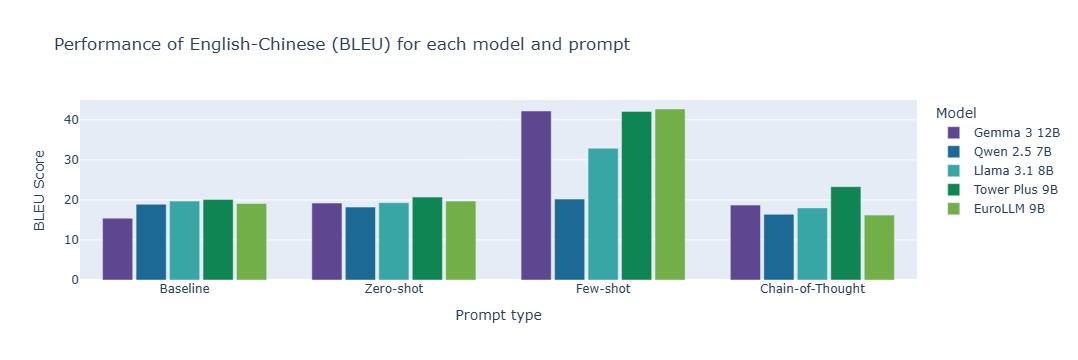

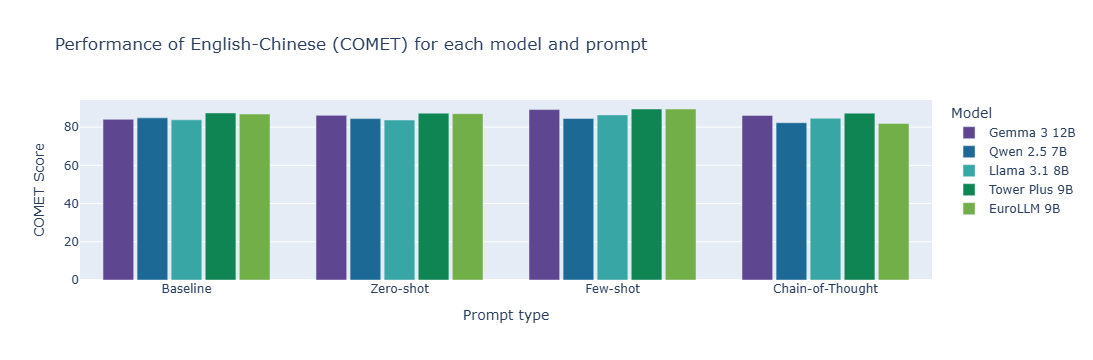

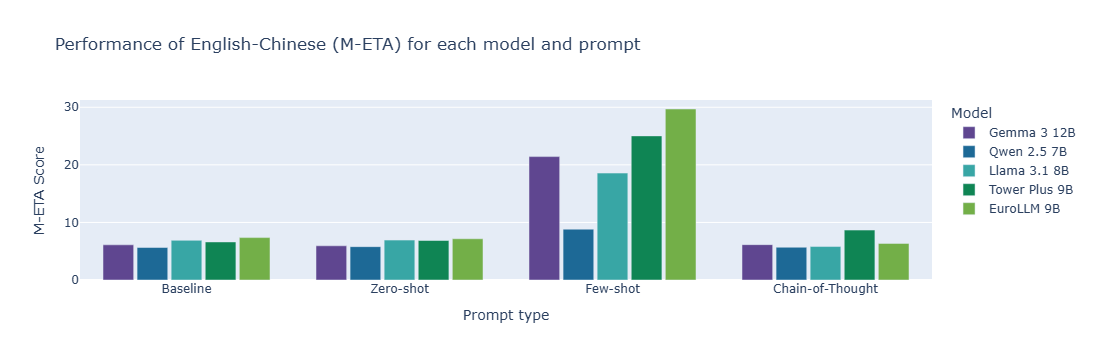

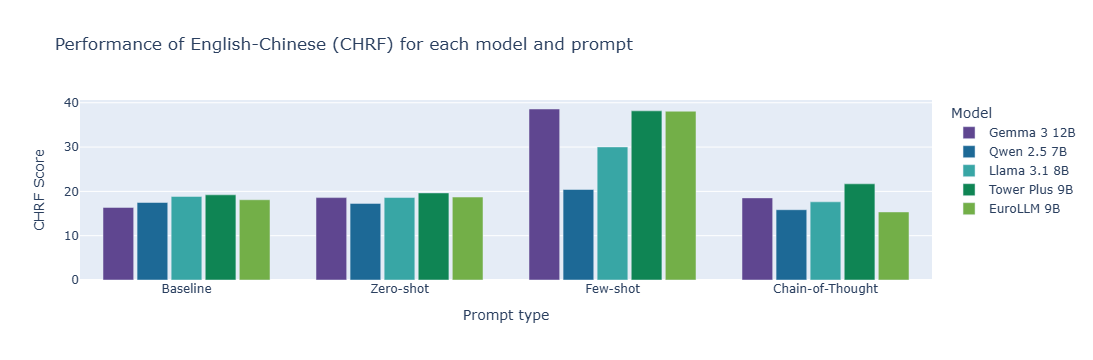

In [352]:
# --- Voorbeelden ---

# 1. Bekijk hoe modellen presteren op Duits met de BLEU score
plot_specific_scenario("Chinese", "BLEU")

# 2. Bekijk Chinees met de COMET score (vaak interessanter voor kwaliteit)
plot_specific_scenario("Chinese", "COMET")

# 3. Bekijk Turks met de m-ETA score
plot_specific_scenario("Chinese", "M-ETA")

# 4. Bekijk Spaans met CHRF
plot_specific_scenario("Chinese", "CHRF")

In [329]:
src = "Prompt-Engineered_translation/Llama/COT/translation_COT_LLAMA_JP.csv"
dst = "translation_FS_Llama_JP.ja"

new_lines = []

with open(src, "r", encoding="utf-8") as f:
    for line in f:
        # hier kun je bewerking doen als je wilt
        new_lines.append(line)

with open(dst, "w", encoding="utf-8") as f:
    f.writelines(new_lines)
